In [6]:
!git clone https://github.com/open-edge-platform/anomalib.git

fatal: destination path 'anomalib' already exists and is not an empty directory.


In [4]:
!git checkout f6ec1c57363a9894ff57184a5bfb78efa8f3de1b

fatal: not a git repository (or any of the parent directories): .git


In [7]:
%cd anomalib

/content/anomalib/src/anomalib


In [11]:
!pip install -q -e ".[dev,cpu]"

  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.7/39.7 MB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.6/729.6 kB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.0/225.0 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 824.2/824.2 kB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 97.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [12]:
%cd src

/content/anomalib/src


In [13]:
from anomalib.models import Patchcore
from anomalib.engine import Engine
from anomalib.data import Folder
from anomalib.data.utils import TestSplitMode, ValSplitMode
from anomalib.post_processing import PostProcessor
from anomalib.metrics import ManualThreshold
from torchvision.transforms import v2
from pathlib import Path


TRAIN_DIR = "/content/data/train/good"
TEST_NORMAL_DIR = "/content/data/test/good"
TEST_ABNORMAL_DIR = "/content/data/test/bad"
PREDICT_DIR = "/content/data/predict"
IMAGE_SIZE = (256, 256)


img_preprocess = v2.Compose([
    v2.Resize(IMAGE_SIZE),
    v2.ToTensor(),
])

# Custom DataModule
datamodule = Folder(
    name="plastic_part",
    root=None,
    normal_dir=TRAIN_DIR,
    abnormal_dir=TEST_ABNORMAL_DIR,
    normal_test_dir=TEST_NORMAL_DIR,
    test_split_mode=TestSplitMode.FROM_DIR,
    val_split_mode=ValSplitMode.FROM_TEST,
    val_split_ratio=0.5,
    train_batch_size=8,
    eval_batch_size=8,
    num_workers=2,
    train_augmentations=img_preprocess,
    val_augmentations=img_preprocess,
    test_augmentations=img_preprocess,
)

datamodule.setup()

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [14]:
# Declare PostProcessor
if MANUAL_THRESHOLD is not None:
    post_processor = PostProcessor()
    post_processor._image_threshold = ManualThreshold(default_value=MANUAL_THRESHOLD)
else:
    post_processor = PostProcessor()

In [15]:
# Train
model = Patchcore(coreset_sampling_ratio=1.0, post_processor=post_processor)
engine = Engine()

engine.train(datamodule=datamodule, model=model)


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'post_processor' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['post_processor'])`.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/276M [00:00<?, ?B/s]

INFO:lightning_fabric.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning_fabric.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning_fabric.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:lightning_fabric.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
INFO: 
  | Name           | Type           | Param

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]



Selecting Coreset Indices.:   0%|          | 0/24576 [00:00<?, ?it/s]

Selecting Coreset Indices.:   0%|          | 1/24576 [00:00<53:52,  7.60it/s]

Selecting Coreset Indices.:   1%|          | 239/24576 [00:00<00:19, 1242.15it/s]

Selecting Coreset Indices.:   3%|▎         | 652/24576 [00:00<00:09, 2473.02it/s]

Selecting Coreset Indices.:   4%|▍         | 1087/24576 [00:00<00:07, 3181.35it/s]

Selecting Coreset Indices.:   6%|▌         | 1532/24576 [00:00<00:06, 3623.89it/s]

Selecting Coreset Indices.:   8%|▊         | 1977/24576 [00:00<00:05, 3897.45it/s]

Selecting Coreset Indices.:  10%|▉         | 2422/24576 [00:00<00:05, 4073.74it/s]

Selecting Coreset Indices.:  12%|█▏        | 2851/24576 [00:00<00:05, 4139.82it/s]

Selecting Coreset Indices.:  13%|█▎        | 3298/24576 [00:00<00:05, 4239.37it/s]

Selecting Coreset Indices.:  15%|█▌        | 3742/24576 [00:01<00:04, 4298.40it/s]

Selecting Coreset Indices.:  17%|█▋        | 4189/24576 [00:01<00:04, 4350.06it/s]

Selecting 

Testing: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric AUROC was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric F1Score was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.5959596037864685     │
│       image_F1Score       │    0.5600000023841858     │
└───────────────────────────┴───────────────────────────┘

[{'image_AUROC': 0.5959596037864685, 'image_F1Score': 0.5600000023841858}]

In [17]:
# 예측
from anomalib.data import PredictDataset
dataset = PredictDataset(
    path=Path(PREDICT_DIR),
    image_size=IMAGE_SIZE,
)

predictions = engine.predict(model=model, dataset=dataset)



INFO:lightning_fabric.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor, PreProcessor
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [23]:
if predictions is not None:
    for prediction in predictions:
        image_path = prediction.image_path
        anomaly_map = prediction.anomaly_map
        pred_label = prediction.pred_label  # (0: normal, 1: anomalous)
        pred_score = prediction.pred_score
print(f"Total predictions: {len(predictions)}\n")

for i, p in enumerate(predictions[10:]):
    print(f"[{i}]")
    print(" image_path:", p.image_path)
    print(" pred_label:", p.pred_label)    # 0=normal, 1=anomalous
    print(" pred_score:", p.pred_score)
    print(" anomaly_map type:", type(p.anomaly_map))
    print(" anomaly_map shape:", getattr(p.anomaly_map, 'shape', None)
          if hasattr(p.anomaly_map, 'shape') else 'N/A')
    print("-" * 40)


Total predictions: 57

[0]
 image_path: ['/content/data/predict/left_FLIR_Blackfly-S-BFS-U3-200S6C_23524388_1_1746110555_jpg_rf_4cfafcc11c6332bb38e4424b5095fd19_1.jpg']
 pred_label: tensor([False])
 pred_score: tensor([0.])
 anomaly_map type: <class 'torchvision.tv_tensors._mask.Mask'>
 anomaly_map shape: torch.Size([1, 256, 256])
----------------------------------------
[1]
 image_path: ['/content/data/predict/left_FLIR_Blackfly-S-BFS-U3-200S6C_23524388_1_1746110601_jpg_rf_23c8458fd10dde86a19191a46fc54052_1.jpg']
 pred_label: tensor([False])
 pred_score: tensor([0.])
 anomaly_map type: <class 'torchvision.tv_tensors._mask.Mask'>
 anomaly_map shape: torch.Size([1, 256, 256])
----------------------------------------
[2]
 image_path: ['/content/data/predict/left_FLIR_Blackfly-S-BFS-U3-200S6C_23524388_1_1746110638_jpg_rf_d7d4241958717eb8721325bd70b7a219_1.jpg']
 pred_label: tensor([False])
 pred_score: tensor([0.])
 anomaly_map type: <class 'torchvision.tv_tensors._mask.Mask'>
 anomaly_ma

# ROC based Threshold

In [48]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve
from sklearn.preprocessing import MinMaxScaler


MAX_FNR = 0.8

LABELS_CSV = "/content/config/labelN.csv"
gt = pd.read_csv(LABELS_CSV)
assert {"filename", "label"} <= set(gt.columns), "No filename & label in label.csv"

# predictions → DataFrame
rows = []
for p in predictions:
    path = p.image_path[0] if isinstance(p.image_path, list) else p.image_path
    rows.append({
        "filename": str(path).split("/")[-1],
        "pred_score": float(p.pred_score.flatten()[0]),
    })
pred_df = pd.DataFrame(rows)

# GT merge
data = pred_df.merge(gt, on="filename", how="inner")
print("\nMerged shape:", data.shape)
if data.empty:
    raise RuntimeError("No matching GT labels ")

y_true = data["label"].astype(int).to_numpy()
scores_raw = data["pred_score"].astype(float).to_numpy()


def youden_with_fnr_constraint(y_true, scores, max_fnr=0.2):
    min_recall = 1.0 - max_fnr
    fpr, tpr, thresholds = roc_curve(y_true, scores, pos_label=1)
    finite = np.isfinite(thresholds)
    fpr, tpr, thresholds = fpr[finite], tpr[finite], thresholds[finite]

    if thresholds.size == 0:
        return float(np.median(scores)), {"reason": "no_finite_thresholds"}

    youden = tpr - fpr
    mask = (tpr >= min_recall)
    if np.any(mask):
        idxs = np.where(mask)[0]
        best_idx = idxs[np.argmax(youden[idxs])]
        reason = "youden_max_with_fnr_constraint"
    else:
        best_idx = np.argmax(tpr)
        reason = "fallback_max_recall"

    thr = float(thresholds[best_idx])
    return thr, {"reason": reason, "tpr": float(tpr[best_idx]), "fpr": float(fpr[best_idx])}

best_thr_raw, info = youden_with_fnr_constraint(y_true, scores_raw, max_fnr=MAX_FNR)

scaler = MinMaxScaler()
scores_norm = scaler.fit_transform(scores_raw.reshape(-1, 1)).flatten()

thr_norm = scaler.transform([[best_thr_raw]])[0, 0]

data["score_norm"] = scores_norm
data["predicted_label"] = (scores_raw >= best_thr_raw).astype(int)

print(f"\n[ROC–Youden + FNR≤{MAX_FNR:.2f}] Best threshold(raw) = {best_thr_raw:.6f}")
print(f"→ Normalized threshold = {thr_norm:.6f}")
print(f"Reason={info['reason']}, TPR={info['tpr']}, FPR={info['fpr']}")

print("\nSample results:")
print(data.head())




Merged shape: (57, 3)

[ROC–Youden + FNR≤0.20] Best threshold(raw) = 23.084789
→ Normalized threshold = 0.000000
Reason=youden_max_with_fnr_constraint, TPR=1.0, FPR=1.0

Sample results:
                                            filename  pred_score  label  \
0  left_FLIR_Blackfly-S-BFS-U3-200S6C_23524388_1_...   39.462963      0   
1  left_FLIR_Blackfly-S-BFS-U3-200S6C_23524388_1_...   40.697475      0   
2  left_FLIR_Blackfly-S-BFS-U3-200S6C_23524388_1_...   54.199146      0   
3  left_FLIR_Blackfly-S-BFS-U3-200S6C_23524388_1_...   55.508892      0   
4  left_FLIR_Blackfly-S-BFS-U3-200S6C_23524388_1_...   55.119827      0   

   score_norm  predicted_label  
0    0.333727                1  
1    0.358882                1  
2    0.633996                1  
3    0.660684                1  
4    0.652757                1  


# F1 Adaptive Threshold (default)

In [ ]:
import os, json, numpy as np, pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


rows = []
if len(predictions) > 0 and hasattr(predictions[0], "pred_score") and hasattr(predictions[0], "pred_label"):
    for p in predictions:
        path = p.image_path[0] if isinstance(p.image_path, list) else p.image_path
        score = float(p.pred_score.flatten()[0])
        label = int(p.pred_label)
        rows.append({
            "filename": os.path.basename(str(path)),
            "pred_score": score,
            "predicted_label": label,
        })
else:
    raise RuntimeError("predictions is empty")

pred_df = pd.DataFrame(rows)
print("Predictions head:")
print(pred_df.head())

# Map with GT labels
labels_path = "/content/config/label.csv"  #  (0=normal,1=anomaly)
gt_df = pd.read_csv(labels_path)
assert {"filename", "label"} <= set(gt_df.columns), "No filename & label columns in the label.csv"

data = pred_df.merge(gt_df, on="filename", how="inner")
print(f"Merged rows: {len(data)} / pred={len(pred_df)} gt={len(gt_df)}")
if len(data) == 0:
    raise RuntimeError("No matching labels")

y_true = data["label"].astype(int).values
y_pred = data["predicted_label"].astype(int).values

# Metrics calculation
acc  = float(accuracy_score(y_true, y_pred))
prec = float(precision_score(y_true, y_pred, zero_division=0))
rec  = float(recall_score(y_true, y_pred, zero_division=0))
f1   = float(f1_score(y_true, y_pred, zero_division=0))

# Save output
out_dir = "../../output2"
os.makedirs(out_dir, exist_ok=True)

# predictions.csv
pred_csv = os.path.join(out_dir, "predictions.csv")
data[["filename", "pred_score", "predicted_label"]].to_csv(pred_csv, index=False)
print("Saved:", pred_csv)

# metrics.json
metrics_json = os.path.join(out_dir, "metrics.json")
with open(metrics_json, "w") as f:
    json.dump({
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "n_samples": int(len(data)),
    }, f, indent=2)
print("Saved:", metrics_json)

print(data.head())
print({"accuracy": acc, "precision": prec, "recall": rec, "f1": f1})


Predictions head:
                                            filename  pred_score  \
0  left_FLIR_Blackfly-S-BFS-U3-200S6C_23524388_1_...    0.063767   
1  left_FLIR_Blackfly-S-BFS-U3-200S6C_23524388_1_...    0.518926   
2  left_FLIR_Blackfly-S-BFS-U3-200S6C_23524388_1_...    1.000000   
3  left_FLIR_Blackfly-S-BFS-U3-200S6C_23524388_1_...    1.000000   
4  left_FLIR_Blackfly-S-BFS-U3-200S6C_23524388_1_...    1.000000   

   predicted_label  
0                0  
1                1  
2                1  
3                1  
4                1  
Merged rows: 57 / pred=57 gt=57
Saved: ../../output2/predictions.csv
Saved: ../../output2/metrics.json
                                            filename  pred_score  \
0  left_FLIR_Blackfly-S-BFS-U3-200S6C_23524388_1_...    0.063767   
1  left_FLIR_Blackfly-S-BFS-U3-200S6C_23524388_1_...    0.518926   
2  left_FLIR_Blackfly-S-BFS-U3-200S6C_23524388_1_...    1.000000   
3  left_FLIR_Blackfly-S-BFS-U3-200S6C_23524388_1_...    1.000000   
4  l

# Save Heatmaps & Overlays

In [ ]:

import os, json, numpy as np, pandas as pd
import numpy as np
from PIL import Image
try:
    import cv2
except Exception as e:
    raise RuntimeError("Install OpenCV") from e

heat_dir = os.path.join(out_dir, "heatmap")
overlay_dir = os.path.join(out_dir, "heatmap_overaly")
os.makedirs(heat_dir, exist_ok=True)
os.makedirs(overlay_dir, exist_ok=True)


pred_label_by_filename = {fn: int(lbl) for fn, lbl in zip(data["filename"], data["predicted_label"])}

def _tensor_to_numpy(x):
    if hasattr(x, "detach"):
        return x.detach().cpu().numpy()
    return np.asarray(x)

def _normalize_heatmap(h):
    h = np.asarray(h, dtype=np.float32)
    if h.ndim >= 3:
        h = np.squeeze(h)
    h_min, h_max = float(h.min()), float(h.max())
    return (h - h_min) / (h_max - h_min + 1e-8)

def _save_one(orig_path, heatmap_arr, score=None, predicted_label=None):
    fname = os.path.basename(str(orig_path))
    stem, _ = os.path.splitext(fname)

    overlay_path = os.path.join(overlay_dir, f"{stem}_overlay.jpg")
    heatmap_path = os.path.join(heat_dir,   f"{stem}_heatmap.jpg")


    img_bgr = cv2.imread(str(orig_path))
    if img_bgr is None:
        img_rgb = np.array(Image.open(orig_path).convert("RGB"))
        img_bgr = img_rgb[..., ::-1].copy()  # RGB -> BGR

    H, W = img_bgr.shape[:2]


    hm_resized = cv2.resize(heatmap_arr, (W, H), interpolation=cv2.INTER_LINEAR)
    hm_uint8 = (hm_resized * 255.0).clip(0, 255).astype(np.uint8)
    hm_color = cv2.applyColorMap(hm_uint8, cv2.COLORMAP_JET)


    overlay = cv2.addWeighted(img_bgr, 0.6, hm_color, 0.4, 0)


    txt_parts = []
    if score is not None:
        txt_parts.append(f"Score={float(score):.4f}")
    if predicted_label is not None:
        txt_parts.append(f"Pred={int(predicted_label)}")
    if txt_parts:
        cv2.putText(overlay, " | ".join(txt_parts), (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2, cv2.LINE_AA)


    cv2.imwrite(overlay_path, overlay)
    cv2.imwrite(heatmap_path, hm_color)

print("Saving heatmaps...")
saved = 0


if len(predictions) > 0 and hasattr(predictions[0], "pred_score"):

    total = len(predictions)
    for i, p in enumerate(predictions, 1):
        path = p.image_path[0] if isinstance(p.image_path, list) else p.image_path
        amap = getattr(p, "anomaly_map", None)
        if amap is None:
            continue
        h = _tensor_to_numpy(amap)
        if h.ndim == 3:  # (1,H,W) → (H,W)
            h = h[0]
        h = _normalize_heatmap(h)

        score = float(p.pred_score.flatten()[0]) if hasattr(p, "pred_score") else None
        plabel = pred_label_by_filename.get(os.path.basename(str(path)))
        _save_one(path, h, score, plabel)
        saved += 2  # overlay + heatmap
        if i % 50 == 0 or i == total:
            print(f"  - LIST {i}/{total} processed")
else:
  raise RuntimeError("Predictions is empty.")

print(f"Saved {saved} images to:\n  - {heat_dir}\n  - {overlay_dir}")


Saving heatmaps...
  - LIST 50/57 processed
  - LIST 57/57 processed
Done. Saved 114 images to:
  - ../../output2/heatmap
  - ../../output2/heatmap_overaly


# Sample - Visualization

Image: /content/data/predict/left_FLIR_Blackfly-S-BFS-U3-200S6C_23524388_1_1746110079_jpg_rf_f919e6fc3589907cc2cda463be379823_1.jpg
Score: 0.0638 | Label: 0 (0=normal, 1=anomalous)


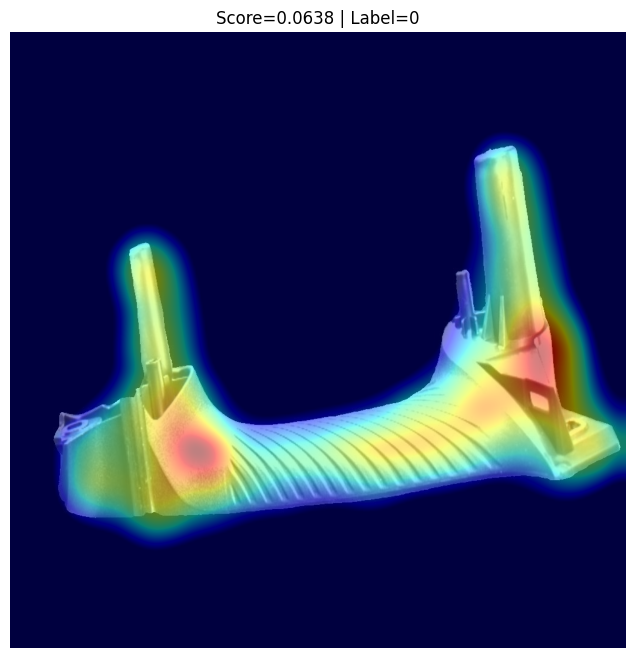

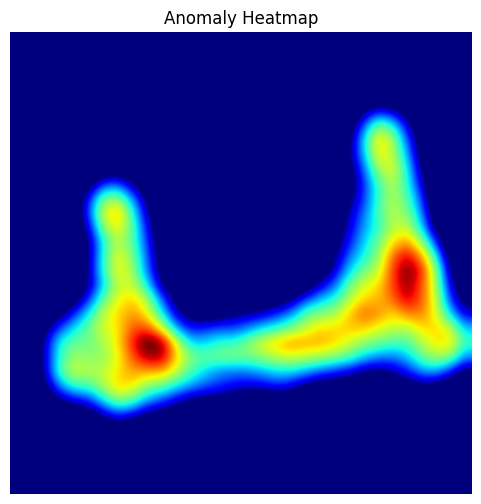

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


p = predictions[0]

image_path = p.image_path[0]
pred_score = float(p.pred_score.item())
pred_label = int(p.pred_label.item())

print(f"Image: {image_path}")
print(f"Score: {pred_score:.4f} | Label: {pred_label} (0=normal, 1=anomalous)")

# heatmap (Mask -> numpy array)
heatmap = p.anomaly_map.numpy()[0]  # shape: (256, 256)
heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)


orig = Image.open(image_path).convert("RGB")
orig_w, orig_h = orig.size

import cv2
heatmap_resized = cv2.resize(heatmap, (orig_w, orig_h))

# Img + heatmap overlay
plt.figure(figsize=(8, 8))
plt.imshow(orig)
plt.imshow(heatmap_resized, cmap='jet', alpha=0.5)
plt.axis("off")
plt.title(f"Score={pred_score:.4f} | Label={pred_label}")
plt.show()

# Heatmap only
plt.figure(figsize=(6, 6))
plt.imshow(heatmap_resized, cmap='jet')
plt.axis("off")
plt.title("Anomaly Heatmap")
plt.show()

